In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras.layers import Input
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate,Activation
from tensorflow.keras.layers import BatchNormalization

In [2]:
#!rm -r ./pricing_model/data
#!rm -r ./pricing_model/__MACOSX
#!rm -r ./pricing_model/data.zip

In [3]:
#!gdown "1-88ggVpy3owfDbB56qXgNySrNQCYYWL8&confirm=t"
#import zipfile
#with zipfile.ZipFile("./data.zip", 'r') as zip_ref:
#    zip_ref.extractall("./pricing_model")

In [4]:
%matplotlib inline


In [5]:
path_to_csv = "./pricing_model/data/housing_data.csv"
image_dir = "./pricing_model/data/images/" 
column_names = ["id", "url", "imageurl", "header", "price", "sqmprice", "sqm", "floor", "rooms", "bedrooms", "address"]


In [6]:
df = pd.read_csv(path_to_csv, names=column_names, header=None)
image_files = set(os.listdir(image_dir))
available_ids = {int(filename.split('.')[0]) for filename in os.listdir(image_dir) if filename.endswith('.jpg')}
df = df[df.index.isin(available_ids)]
df = df.dropna() # We lost 5% of the data, problem seems to be with the method of scraping or the website error itself
df.drop(['url', 'imageurl'], axis=1, inplace=True)

In [7]:
def modify_address(addr):
    # Split the address string by comma and retain everything after the first comma
    parts = addr.split(',', 1)  # Split only at the first comma
    return parts[1].strip() if len(parts) > 1 else addr

In [8]:
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

# Filter the dataframe using the mask
df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)
df['address'] = df['address'].str.replace(', ', '', regex=True)
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)

mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() > 40].index)

df = df[mask]

In [9]:
df['address'] = df['address'].str.replace(', ', '', regex=True)

In [10]:
df[df['address'].str.startswith('')]

,id,header,price,sqmprice,sqm,floor,rooms,bedrooms,address
0,0,იყიდება ახალი აშენებული ბინა მთაწმინდაზე,"210,000",3134.0,67.00 მ²,სარ. 5,ოთ. 3,საძ. 2,მთაწმინდამთაწმინდის რაიონითბილისი
1,1,იყიდება ძველი აშენებული ბინა დიდუბეში,"185,000",1595.0,116.00 მ²,სარ. 4,ოთ. 5,საძ. 4,ა. წერეთლის გამზირიდიდუბედიდუბის რაიონითბილისი
3,3,იყიდება ახალი აშენებული ბინა ორთაჭალაში,"138,000",1917.0,72.00 მ²,სარ. 7,ოთ. 3,საძ. 2,ვ. გორგასლის ქუჩაორთაჭალაკრწანისის რაიონითბილისი
5,5,იყიდება ახალი აშენებული ბინა დიდ დიღომში,"60,000",1200.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,დიდი დიღომისაბურთალოს რაიონითბილისი
6,6,იყიდება ძველი აშენებული ბინა ვაზისუბანში,"55,000",833.0,66.00 მ²,სარ. 5,ოთ. 3,საძ. 2,შ. პეტეფის ქუჩავაზისუბანიისნის რაიონითბილისი
...,...,...,...,...,...,...,...,...,...
63091,63093,იყიდება ახალი აშენებული ბინა ვარკეთილის მასივი...,"78,000",975.0,80.00 მ²,სარ. 6,ოთ. 3,საძ. 2,ვარკეთილის მასივი IIIვარკეთილი-3 III მ/რვარკეთ...
63092,63094,იყიდება ახალი აშენებული ბინა საბურთალოზე,"180,000",1385.0,130.00 მ²,სარ. 7,ოთ. 4,საძ. 3,ს. ჩიქოვანის ქუჩასაბურთალოსაბურთალოს რაიონითბი...
63093,63095,იყიდება ახალი აშენებული ბინა საბურთალოზე,"89,000",1935.0,46.00 მ²,სარ. 17,ოთ. 2,საძ. 1,ბერბუკის ქუჩასაბურთალოსაბურთალოს რაიონითბილისი
63094,63096,იყიდება ახალი აშენებული ბინა ნაძალადევში,"85,000",1700.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,ც. დადიანის ქუჩანაძალადევინაძალადევის რაიონითბ...


In [11]:
df["address"].value_counts()

დიდი დიღომისაბურთალოს რაიონითბილისი                                1755
საბურთალოსაბურთალოს რაიონითბილისი                                  1603
ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთალოს რაიონითბილისი    1603
ი. ჭავჭავაძის გამზირივაკევაკის რაიონითბილისი                       1107
ვაკევაკის რაიონითბილისი                                             897
                                                                   ... 
მუსხელიშვილის ქუჩავაზისუბანიისნის რაიონითბილისი                      42
ლილოს დას.სამგორის რაიონითბილისი                                     42
წყნეთის ქუჩავაკევაკის რაიონითბილისი                                  41
გლდანი 4 მკრ.გლდანის მასივიგლდანის რაიონითბილისი                     41
ლერწამის ქუჩაისანიისნის რაიონითბილისი                                41
Name: address, Length: 265, dtype: int64

In [12]:
df['status'] = df['header'].str.split().str.get(1)
df['location_name'] = df['header'].str.replace("იყიდება ახალი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება ძველი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება მშენებარე ბინა ", "", regex=False).str.strip()

value_counts = df['location_name'].value_counts()
print(value_counts)
# Keep only rows where the 'location_name' value count is >= 30
df = df[df['location_name'].isin(value_counts[value_counts >= 30].index)]
df.drop(['header'], axis=1, inplace=True)


საბურთალოზე        10891
ვაკეში              4439
დიდ დიღომში         3164
დიდუბეში            2230
გლდანის მასივში     2106
                   ...  
ივერთუბანში            1
დიდ ლილოშ              1
ბერთუბანში             1
სოფელ გლდანში          1
ახალდაბაში             1
Name: location_name, Length: 108, dtype: int64


In [13]:
df["price"] = df["price"].str.replace(",", "").astype(float)
df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)
df.drop("sqmprice", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)



/tmp/ipykernel_713/3070115346.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
/tmp/ipykernel_713/3070115346.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
/tmp/ipykernel_713/3070115346.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)


In [14]:
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"Number of jpg images in {image_dir}: {len(image_files)}")


Number of jpg images in ./pricing_model/data/images/: 57837


In [15]:
df = df[df["price"] <= 500000]
df = df[df["price"] >= 10000]


In [16]:
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()
df[['sqm', 'floor', 'rooms', 'bedrooms']] = scaler.fit_transform(df[['sqm', 'floor', 'rooms', 'bedrooms']])
df[['price']] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['location_name', "status", "address"])

bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)
# Split the data into training and test sets
y = df['price']
X = df.drop('price', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
# Define paths
base_dir = './pricing_model/data/images_sets/'
train_dir = os.path.join(base_dir, 'train')
dev_dir = os.path.join(base_dir, 'dev')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
#os.makedirs(train_dir, exist_ok=True)
#os.makedirs(dev_dir, exist_ok=True)
#os.makedirs(test_dir, exist_ok=True)

# Move images to respective directories
#for idx in X_train.index:
#    shutil.copy(os.path.join(image_dir, f"{idx}.jpg"), train_dir)

#for idx in X_dev.index:
#    shutil.copy(os.path.join(image_dir, f"{idx}.jpg"), dev_dir)

#for idx in X_test.index:
#    shutil.copy(os.path.join(image_dir, f"{idx}.jpg"), test_dir)


In [18]:
X_train = X_train.sort_index()
y_train = y_train[X_train.index]

X_dev = X_dev.sort_index()
y_dev = y_dev[X_dev.index]

X_test = X_test.sort_index()
y_test = y_test[X_test.index]

In [19]:
img_size = (224, 224)



def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image /= 255.0  # Normalize to [0,1]
    return image, label

train_image_paths = [os.path.join(train_dir, f"{idx}.jpg") for idx in X_train.index]
dev_image_paths = [os.path.join(dev_dir, f"{idx}.jpg") for idx in X_dev.index]
test_image_paths = [os.path.join(test_dir, f"{idx}.jpg") for idx in X_test.index]


# Create datasets from image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, y_train.values))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_image_paths, y_dev.values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, y_test.values))

# Map the datasets to load and preprocess the images
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)



In [20]:
# Convert structured data from pandas DataFrame to TensorFlow Dataset
structured_train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
structured_dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev.values, y_dev.values))
structured_test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

# Batch the datasets
structured_train_dataset = structured_train_dataset.batch(128)
structured_dev_dataset = structured_dev_dataset.batch(128)
structured_test_dataset = structured_test_dataset.batch(128)


In [21]:
# Batch the datasets with batch size of 1
train_dataset = train_dataset.batch(128)
dev_dataset = dev_dataset.batch(128)
test_dataset = test_dataset.batch(128)


In [22]:
# Zip the image and structured datasets together
combined_train_dataset = tf.data.Dataset.zip((train_dataset, structured_train_dataset))
combined_dev_dataset = tf.data.Dataset.zip((dev_dataset, structured_dev_dataset))
combined_test_dataset = tf.data.Dataset.zip((test_dataset, structured_test_dataset))


In [23]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x_img = base_model.output
x_img = Flatten()(x_img)
x_img = Dense(256)(x_img) 
x_img = BatchNormalization()(x_img)
x_img = Activation('relu')(x_img)

input_structured = Input(shape=(X_train.shape[1],))

x_structured = Dense(512)(input_structured) 
x_structured = BatchNormalization()(x_structured)
x_structured = Activation('relu')(x_structured)

x_structured = Dense(256)(x_structured) 
x_structured = BatchNormalization()(x_structured)
x_structured = Activation('relu')(x_structured)

# Combining both sub-models
combined = Concatenate()([x_img, x_structured])
combined = Dense(256)(combined) 
combined = BatchNormalization()(combined)
combined = Activation('relu')(combined)

combined = Dense(128)(combined) 
combined = BatchNormalization()(combined)
combined = Activation('relu')(combined)

output = Dense(1, activation='linear')(combined)

model = Model([base_model.input, input_structured], output)


In [24]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error', metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [25]:
def unpack_data(img_data, struct_data):
    images, label = img_data
    structured_data, _ = struct_data
    return (images, structured_data), label

train_data_for_model = combined_train_dataset.map(unpack_data)
dev_data_for_model = combined_dev_dataset.map(unpack_data)
test_data_for_model = combined_test_dataset.map(unpack_data)

In [26]:
history = model.fit(train_data_for_model, validation_data=dev_data_for_model, epochs=100)


Epoch 1/100
305/305 [==============================] - 174s 547ms/step - loss: 0.1022 - mean_absolute_error: 0.1873 - mean_absolute_percentage_error: 1806.5291 - val_loss: 0.0308 - val_mean_absolute_error: 0.1233 - val_mean_absolute_percentage_error: 58.7625
Epoch 2/100
305/305 [==============================] - 173s 566ms/step - loss: 0.0110 - mean_absolute_error: 0.0773 - mean_absolute_percentage_error: 1655.6383 - val_loss: 0.0142 - val_mean_absolute_error: 0.0875 - val_mean_absolute_percentage_error: 46.9844
Epoch 3/100
305/305 [==============================] - 175s 574ms/step - loss: 0.0064 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 2628.2568 - val_loss: 0.0145 - val_mean_absolute_error: 0.0913 - val_mean_absolute_percentage_error: 51.1657
Epoch 4/100
305/305 [==============================] - 175s 572ms/step - loss: 0.0046 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 3040.8306 - val_loss: 0.0127 - val_mean_absolute_error: 0.0841 - val_mean

In [ ]:
model.save('final_saved_model')

INFO:tensorflow:Assets written to: final_saved_model/assets


INFO:tensorflow:Assets written to: final_saved_model/assets


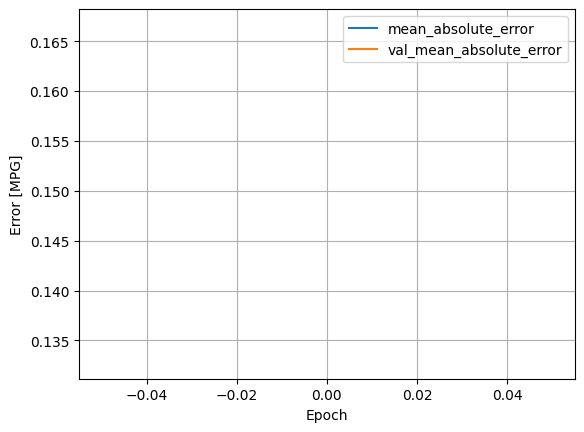

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [ ]:
loss, mae, mape = model.evaluate(dev_data_for_model)
#train_loss, train_mae, train_mape = model.evaluate(train_data_for_model)

print(f"Test Loss: {loss}")
scaled_mae = mae
#scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
#original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {original_mae[0]}")
#print(f"Original train MAE: {original_train_mae[0]}")

39/39 [==============================] - 18s 468ms/step - loss: 0.0320 - mean_absolute_error: 0.1328 - mean_absolute_percentage_error: 79.3874
Test Loss: 0.032040826976299286
Original MAE: 64723.143661022186


In [ ]:
# 1. Predict on test data
y_pred = model.predict(dev_data_for_model)

# Inverse transform the scaled target variable (y_dev)
y_dev_actual = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))

# Inverse transform the scaled predictions (y_pred)
y_pred_actual = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(y_dev_actual.shape)
print(y_pred_actual.shape)

# 2. Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_dev_actual.flatten(),
    'Predicted Values': y_pred_actual.flatten() # flatten is used to convert the 2D array to 1D
})

print(comparison_df)


 4/39 [==>...........................] - ETA: 16s

39/39 [==============================] - 19s 479ms/step
(4868, 1)
(4868, 1)
      Actual Values  Predicted Values
0           55000.0     160802.093750
1          235000.0     135434.218750
2           50200.0     124663.140625
3          210000.0     161727.328125
4          230000.0     163641.625000
...             ...               ...
4863        48000.0      72126.187500
4864       292200.0     234011.734375
4865       103300.0     128294.960938
4866       248000.0      82898.906250
4867       110000.0     221489.593750

[4868 rows x 2 columns]


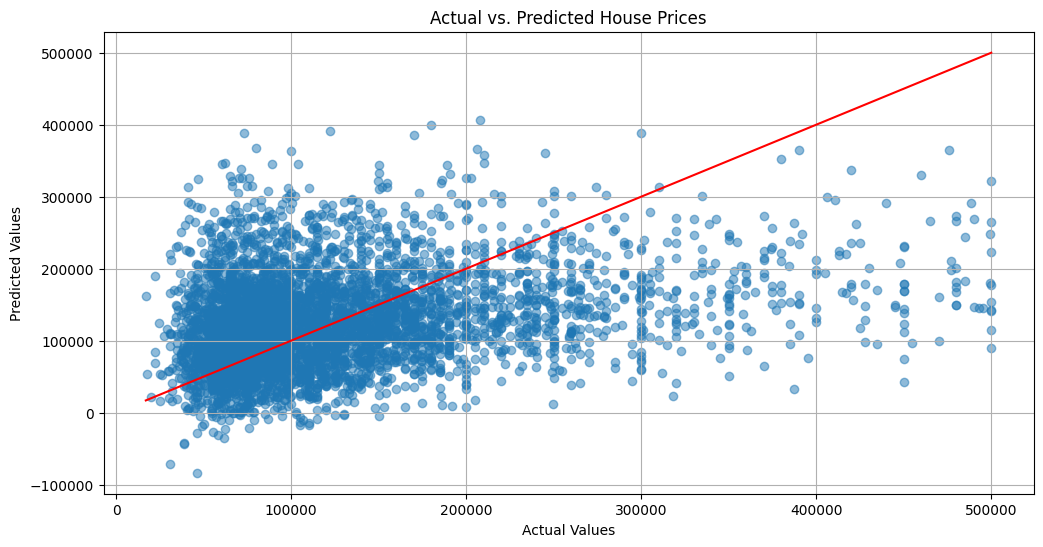

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['Actual Values'], comparison_df['Predicted Values'], alpha=0.5)
plt.plot([min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         [min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         color='red')  # Diagonal line

plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [ ]:
y_pred_test = model.predict(dev_data_for_model)
y_dev_actual_for_r2 = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))
y_pred_actual_for_r2 = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(y_dev_actual_for_r2, y_pred_actual_for_r2)
r2

39/39 [==============================] - 19s 484ms/step


-0.19728770514470462

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_data_for_model)
original_test_mae = test_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original test MAE: {original_mae[0]}")
print(f"Original test MAPE: {test_mape}")


39/39 [==============================] - 22s 498ms/step - loss: 0.0327 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 76.3326
Original test MAE: 64723.143661022186
Original test MAPE: 76.33260345458984


The results are not great they are off by more than 12k which is a significant amount for house prices. Most probable reason is lack of features which will allow model to capture larger variance